# Pre-processing real experimental data

In this notebook, I demonstrate how to restructure real experimental data in the form of .csv files to match a constant dwell time format. This preprocessing step allows the data to better align with what the basecalling model expects or was trained on, enabling more effective downstream basecalling and analysis. Rather than modifying the training data to match experimental conditions, which can be challenging, particularly when aiming to preserve realism, this approach focuses on adapting the experimental data to fit the model's requirements

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import numpy as np
import find_steps

### Example visualisation for a single trace 

In [21]:
input_folder = "JS-Events"
output_folder = "JS-Events-restructured"
summary_csv_path = os.path.join(output_folder, "resampling_summary.csv")

#### Original signal 

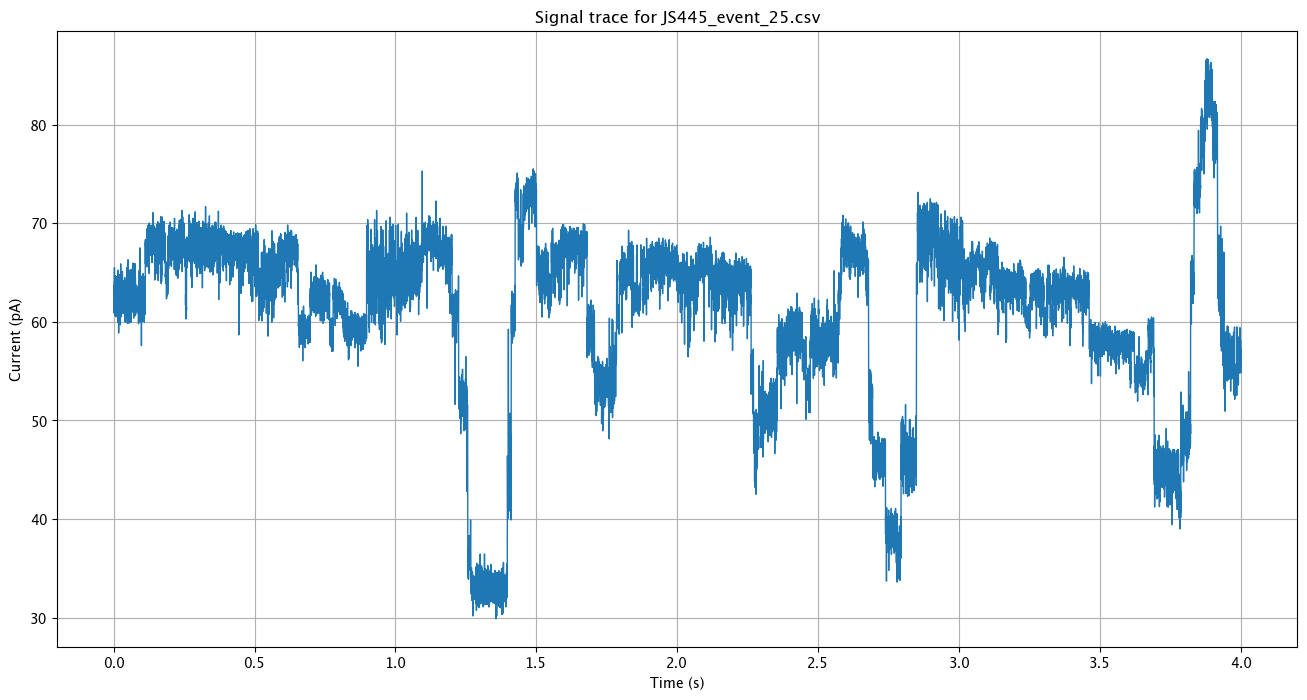

In [22]:
file_name = "JS445_event_25.csv"
file_path = os.path.join(input_folder, file_name)
df = pd.read_csv(file_path) * 180 # to convert to pA

fs = 5000 # sampling rate 
n_samples = len(df)
time = np.arange(n_samples) / fs  # time in seconds

plt.figure(figsize=(16, 8)) 
plt.plot(time, df["RelativeCurrent"], linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("Current (pA)")
plt.title(f"Signal trace for {file_name}")
plt.grid(True)
plt.show()

#### Original signal with detected steps 

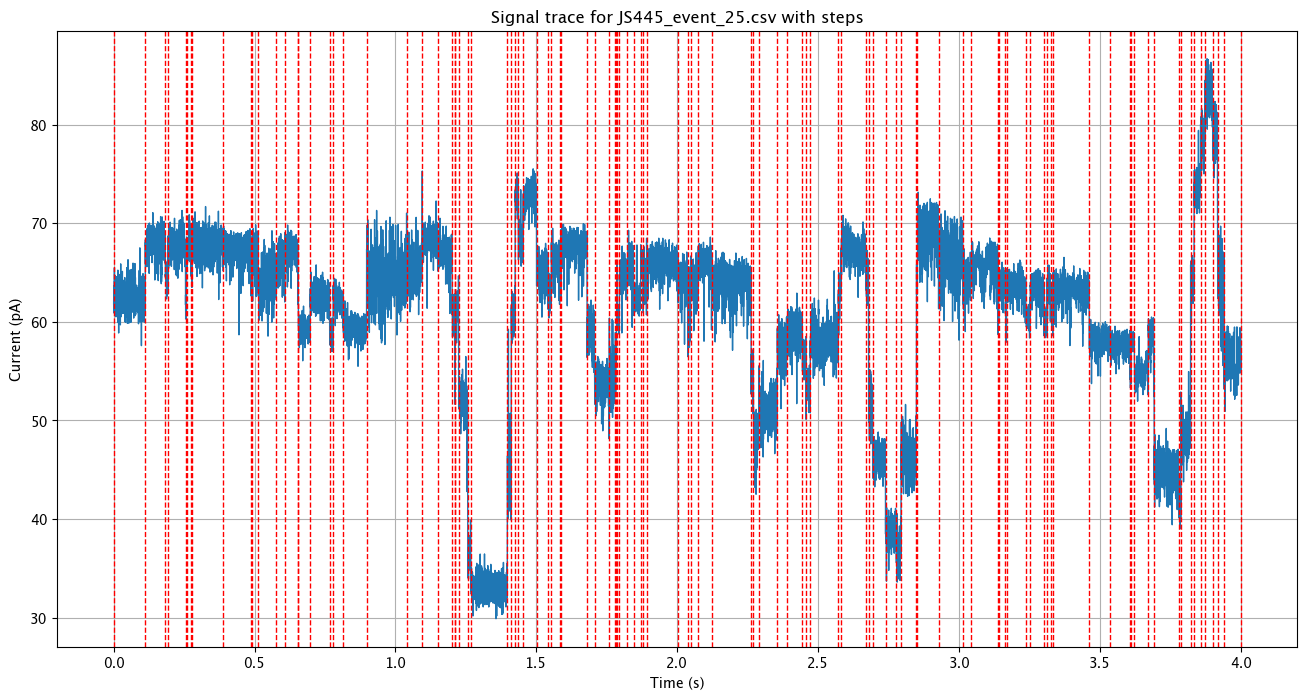

In [23]:
sensitivity = 3
min_step_length = 10
samples_per_step = 10 # this is for one step of the two for Hel308 ---> change this to change dwell time desired 

transitions, features, errors, stiffnesses = find_steps.stepFinder_CPIC(
    df["RelativeCurrent"], sensitivity, min_step_length
)
mean, stds = features[0, :], features[1, :]

plt.figure(figsize=(16, 8)) 
plt.plot(time, df["RelativeCurrent"], linewidth=1)

for x in transitions:
    plt.axvline(x=x/fs, color='red', linestyle='--', linewidth=1)

plt.xlabel("Time (s)")
plt.ylabel("Current (pA)")
plt.title(f"Signal trace for {file_name} with steps")
plt.grid(True)
plt.show()

#### Resampled signal 

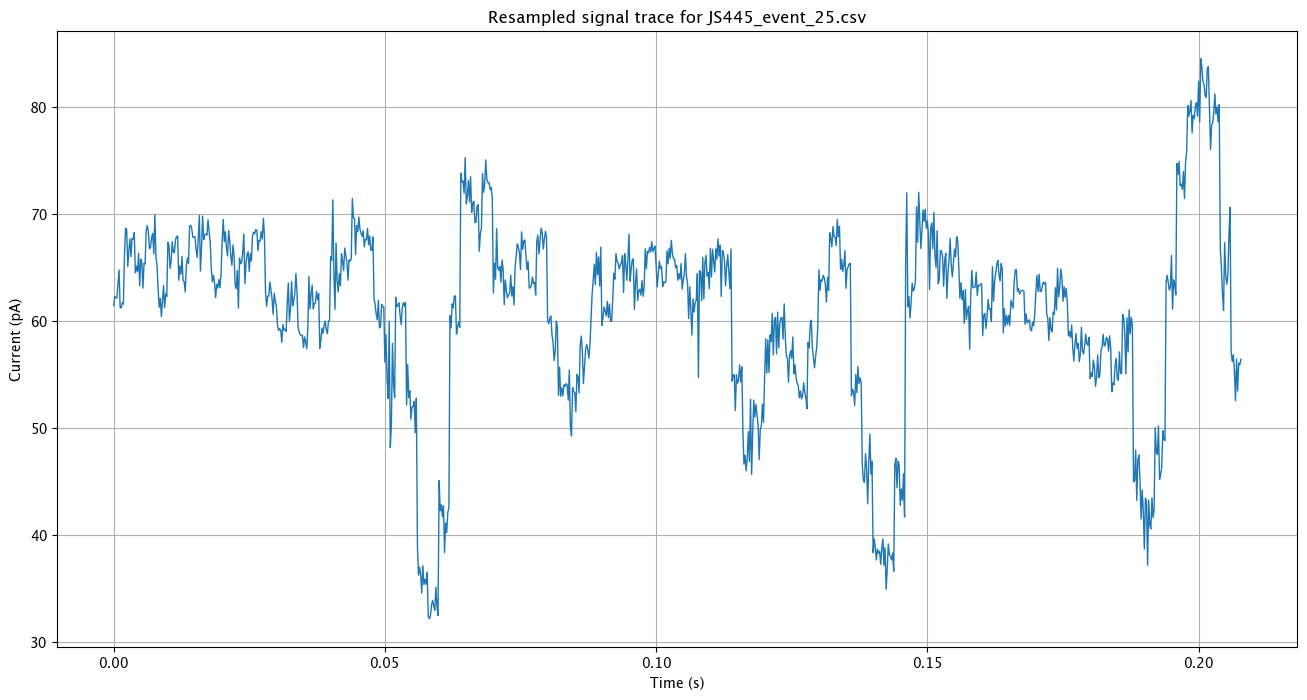

In [24]:
resampled_signal = []
for m, s in zip(mean, stds):
    samples = np.random.normal(loc=m, scale=s, size=samples_per_step)
    resampled_signal.extend(samples)

resampled_signal = np.array(resampled_signal)

n_samples_r = len(resampled_signal)
time_r = np.arange(n_samples_r) / fs  # time in seconds

plt.figure(figsize=(16, 8)) 
plt.plot(time_r, resampled_signal, linewidth=1)

plt.xlabel("Time (s)")
plt.ylabel("Current (pA)")
plt.title(f"Resampled signal trace for {file_name}")
plt.grid(True)
plt.show()

### Apply restructuring to folder of .csv files

In [ ]:
sensitivity = 3
min_step_length = 10
samples_per_step = 10 # this is for one step of the two for Hel308

os.makedirs(output_folder, exist_ok=True)

summary_data = []

for file_path in glob.glob(os.path.join(input_folder, "JS*")):
    print(f"Processing {file_path}...")

    signal = pd.read_csv(file_path)
    signal = signal * 180 # remove the * 180 if experimental data already in terms of pA

    transitions, features, errors, stiffnesses = find_steps.stepFinder_CPIC(
        signal["RelativeCurrent"], sensitivity, min_step_length
    )
    means, stds = features[0, :], features[1, :]

    resampled_signal = []
    for mean, std in zip(means, stds):
        samples = np.random.normal(loc=mean, scale=std, size=samples_per_step)
        resampled_signal.extend(samples)

    resampled_signal = np.array(resampled_signal)
    df = pd.DataFrame(resampled_signal, columns=['RelativeCurrent'])

    base_filename = os.path.basename(file_path)
    base_name_no_ext = os.path.splitext(base_filename)[0]
    output_path = os.path.join(output_folder, f"{base_name_no_ext}_resampled0.002.csv")

    df.to_csv(output_path, index=False)

    predicted_length = len(transitions) // 2
    summary_data.append({"filename": base_filename, "predicted length": predicted_length})

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(summary_csv_path, index=False)

print("Done processing all files.")
print(f"Summary saved to {summary_csv_path}")